## Association-Rule-Based Predictions

This notebook presents a basic pipeline to incorporate transaction predictions to tabular data given a set of already mined association rules (see notebook `Apriori.ipynb` to this end). The main steps are elaborated below:

* [Imports](#imports)
* [Settings](#pathinput)
* [Predictions](#preds)

### Imports <a name="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Settings <a name="pathinput"></a>

In [2]:
my_dir = os.getcwd()

In [3]:
plt.style.use("ggplot")

In [4]:
plot_path = os.path.join(my_dir, "plots")

In [5]:
my_tbl_file = "Training_courses_2019.xlsx"
sheet_name = "courses"

my_tbl_path = os.path.join(my_dir, my_tbl_file)
file_path_dict = {
    "lift": os.path.join(my_dir, "metric-lift"),
    "confidence ratio": os.path.join(my_dir, "metric-confidence-ratio"),
    "confidence difference": os.path.join(my_dir, "metric-confidence-diff")
            }

In [6]:
my_rls_file = "confidence_ratio_c1.csv"
my_rls_path = os.path.join(file_path_dict["confidence ratio"], my_rls_file)

In [7]:
tickets = pd.read_excel(my_tbl_path, sheet_name=sheet_name)
rules = pd.read_csv(my_rls_path, sep=",")

In [8]:
tickets.head()

,TICKET,Decision Trees,Building Predictive Models,Intro to CHAID,Classification and Clustering,Data Entry,FastTrack,Intermediate Techniques,Intro to Statistic platform,Intro to Platform & Statistics,Maps,Perceptual Mapping,Market Segmentation,Neural Networks,Scripting,Intro to Statistics,Tables,Time Series,ANOVA models
0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,32,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,33,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,36,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0


In [9]:
rules.head(3)

,antecedent(s),consequent(s),antecedent frequency,antecedent support,consequent support,confidence,rule support,lift,confidence difference,confidence ratio,size antec.set,size conseq.set,rule ID
0,"Building Predictive Models, Intermediate Techn...",Decision Trees,4,0.011461,0.040115,1.0,0.011461,24.928571,0.959885,0.959885,4,1,690
1,"Intro to Statistic platform, Intro to CHAID, M...",Decision Trees,4,0.011461,0.040115,1.0,0.011461,24.928571,0.959885,0.959885,5,1,852
2,"Building Predictive Models, Intro to CHAID, In...",Decision Trees,4,0.011461,0.040115,1.0,0.011461,24.928571,0.959885,0.959885,4,1,670


### Predictions <a name="preds"></a>

Create a series with the sets of products per ticket:

In [10]:
def make_ticket_set(rowSeries, col_start=1):
    """
    Function meant for vectorization via `pandas.DataFrame.apply()`, with arguments:
    * `rowSeries`
      DataFrame row passed internally when calling `pandas.DataFrame.apply()` with `axis=1`.
    * `col_start`
      Index of the column from which all remaining columns are transactional, i.e. number of columns
      with non-transactional information. These columns are ignored throughout processing.
      By default (1) it is assumed that only one such column exists (the leftmost one).
      
    Note that this function only works if the transactional columns are binary (0/1).
    """
    ticket_set = {rowSeries[name] * name for name in rowSeries.index[col_start:] if rowSeries[name]}
    return ticket_set

In [11]:
ticket_products = tickets.apply(make_ticket_set, axis=1)

Add a column to `rules` containing the sets of antecendents per rule:

In [12]:
rules["antecedent set"] = rules["antecedent(s)"].map(lambda group: {item.strip() for item in group.split(",")})

In [13]:
rules.head(3)

,antecedent(s),consequent(s),antecedent frequency,antecedent support,consequent support,confidence,rule support,lift,confidence difference,confidence ratio,size antec.set,size conseq.set,rule ID,antecedent set
0,"Building Predictive Models, Intermediate Techn...",Decision Trees,4,0.011461,0.040115,1.0,0.011461,24.928571,0.959885,0.959885,4,1,690,"{Market Segmentation, Building Predictive Mode..."
1,"Intro to Statistic platform, Intro to CHAID, M...",Decision Trees,4,0.011461,0.040115,1.0,0.011461,24.928571,0.959885,0.959885,5,1,852,"{Building Predictive Models, Market Segmentati..."
2,"Building Predictive Models, Intro to CHAID, In...",Decision Trees,4,0.011461,0.040115,1.0,0.011461,24.928571,0.959885,0.959885,4,1,670,"{Building Predictive Models, Intro to Statisti..."


Check the applicability of association rules to the itemsets stored in `ticket_products`. To this end, two conditions need to be met:
 * The ticket itemset must contain the entirety of a rule's antecedent set.
 * The ticket itemset must be disjointed with a rule's consequent.
 
Note that the following caveats are to be kept in mind:
 * The function `fit_rules` below assumes **single consequents**. Undesirable behaviour will arise if this is not the case.
 * If multiple rules satisfy the above conditions, the rule with highest confidence is selected.

In [14]:
def fit_rules(products, rules):
    rule_cols = ["consequent(s)", "confidence", "rule ID", "antecedent(s)"]
    condition_ant = rules["antecedent set"].map(lambda aset: aset.issubset(products))
    condition_con = rules["consequent(s)"].map(lambda con: con not in products)
    
    if (condition_ant & condition_con).sum() == 0:
        return "", "", ""
    elif (condition_ant & condition_con).sum() == 1:
        one_rule = rules.loc[condition_ant & condition_con, rule_cols]
        return one_rule.iloc[0, 0], f"{one_rule.iloc[0, 1]:.3f}", one_rule.iloc[0, 2]
    else:
        sorted_rules = rules.loc[condition_ant & condition_con, rule_cols]\
                            .sort_values(["confidence", "antecedent(s)"], ascending=[False, True])
        return sorted_rules.iloc[0, 0], f"{sorted_rules.iloc[0, 1]:.3f}", sorted_rules.iloc[0, 2]

Attach the rule-based predictions, alongside the rule's confidence and ID, to the `tickets` dataframe:

In [15]:
tickets["Rule prediction"], tickets["Rule confidence"], tickets["Rule ID"] =\
  zip(*ticket_products.apply(fit_rules, args=(rules,)))

In [16]:
tickets.head()

,TICKET,Decision Trees,Building Predictive Models,Intro to CHAID,Classification and Clustering,Data Entry,FastTrack,Intermediate Techniques,Intro to Statistic platform,Intro to Platform & Statistics,...,Market Segmentation,Neural Networks,Scripting,Intro to Statistics,Tables,Time Series,ANOVA models,Rule prediction,Rule confidence,Rule ID
0,2,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,,,
1,16,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,Intro to CHAID,0.533,101
2,32,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,,,
3,33,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,,,
4,36,0,0,1,0,0,0,1,1,0,...,1,0,0,1,0,1,0,Building Predictive Models,0.857,427


If necessary, merge the `tickets` dataframe with the corresponding rows from `rules`, to have all the rule related information readily available:

In [17]:
# tickets = tickets.merge(rules[rules.columns[:-1]], how="left", left_on="Rule ID", right_on="rule ID")

If necessary, save the (extended) `tickets` dataframe as a `csv` file, in the same directory as the rules' file:

In [18]:
my_path = os.path.join(file_path_dict["confidence ratio"], os.path.splitext(my_rls_file)[0] + "_predict.csv")
tickets.to_csv(my_path, index=False)

Visualise the frequency of the rule-based predictions, and save the figure in the relevant directory if necessary:

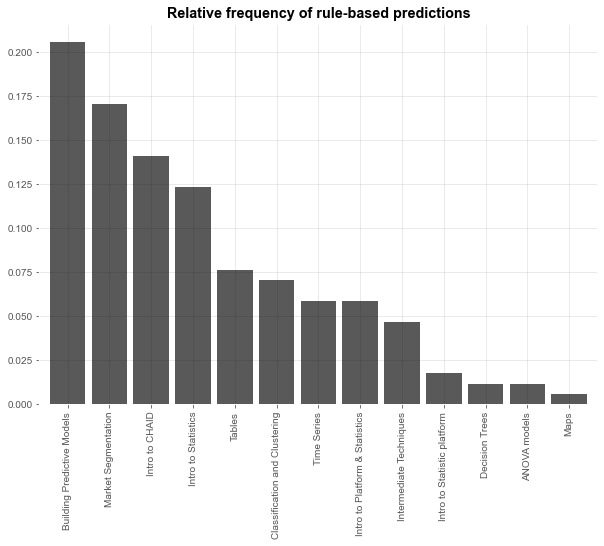

In [19]:
tickets[tickets["Rule prediction"] != '']["Rule prediction"].value_counts(normalize=True)\
                                                            .plot(kind="bar", figsize = (10,7),
                                                                  color='k', alpha=0.65, width=0.85)

font_dict = {'fontname':'Arial'}
ax = plt.gca()
ax.set_facecolor('white')
plt.title('Relative frequency of rule-based predictions', fontweight="semibold", **font_dict)
plt.xticks(rotation = 90, **font_dict)
plt.yticks(**font_dict)
plt.grid(color='k', alpha=0.1)
plt.savefig(os.path.join(plot_path, os.path.splitext(my_rls_file)[0] + "_predict.png"), bbox_inches="tight")
plt.show()